## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.config_ICE import *
from scripts.xgb_helpers import *
from scripts.geodata import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.NorwayConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

"""
# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
"""

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    # "aspect_sgi",  # SGI
    # "slope_sgi",  # SGI
    # "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",  # OGGM
]

## Read GL data:

In [3]:
data_wgms = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 49
Number of winter, summer and annual samples: 6586
Number of annual samples: 3205
Number of winter samples: 3381
Number of summer samples: 0


Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId', 'aspect', 'slope', 'topo',
       'consensus_ice_thickness', 'millan_v', 'GLACIER', 'POINT_ID'],
      dtype='object')

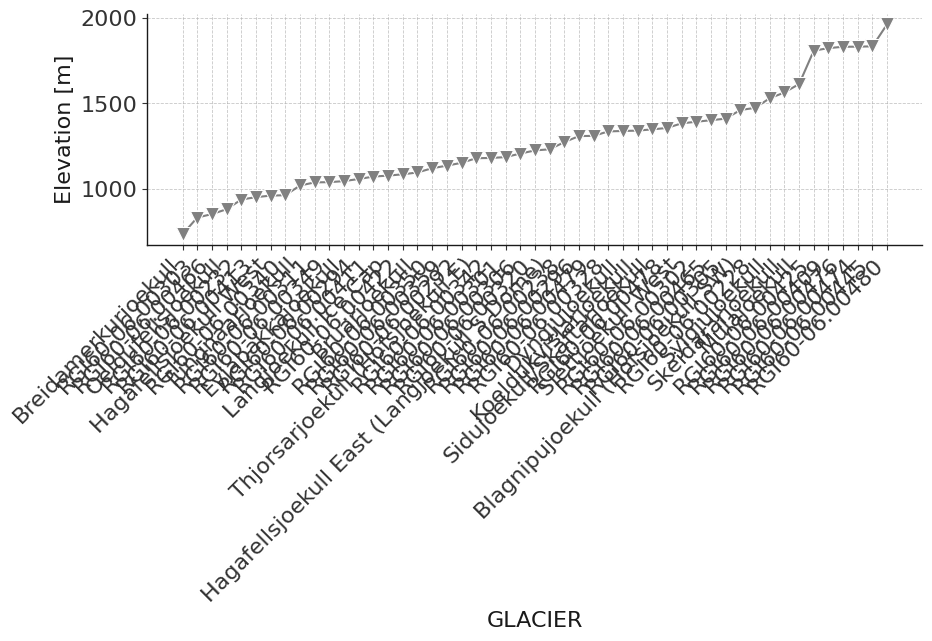

In [4]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier

mean_mb_per_glacier = data_wgms.copy()
mean_mb_per_glacier['YEAR'] = mean_mb_per_glacier['TO_DATE'].astype(str).str[:4].astype(int)

mean_mb_per_glacier = mean_mb_per_glacier.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] == 'winter']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_wgms.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 3))  # Made figure slightly taller for labels
ax = plt.subplot(1, 1, 1)
sorted_elevations = gl_per_el.sort_values(ascending=True)

sns.lineplot(sorted_elevations,
             ax=ax,
             color='gray',
             marker='v')

# Add glacier names as x-tick labels
ax.set_xticks(range(len(sorted_elevations)))
ax.set_xticklabels(sorted_elevations.index, rotation=45, ha='right')
ax.set_ylabel('Elevation [m]')
plt.tight_layout()

In [5]:
data_wgms_test = data_wgms.copy()

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_WGMS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure.nc'
    #'radiation_save_path': path_pcsr + 'zarr/'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='ICE_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-05-27 07:32:21,900 - INFO - Number of annual and seasonal samples: 6586
2025-05-27 07:32:21,904 - INFO - Running on 49 glaciers:
['Thjorsarjoekull (Hofsjoekull E)' 'Sidujoekull/Skaftarjoekull'
 'Breidamerkurjoekull' 'Dyngjujoekull' 'RGI60-06.00328' 'Tungnaarjoekull'
 'Hagafellsjoekull West' 'Eyjabakkajoekull' 'RGI60-06.00303'
 'Langjoekull Ice Cap' 'Koeldukvislarjoekull' 'Oeldufellsjoekull'
 'Skeidararjoekull' 'Slettjoekull West' 'RGI60-06.00466' 'RGI60-06.00411'
 'RGI60-06.00302' 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238' 'RGI60-06.00320'
 'Sylgjujoekull' 'Hagafellsjoekull East (Langjoekull S Dome)'
 'RGI60-06.00342' 'RGI60-06.00480' 'RGI60-06.00465' 'RGI60-06.00294'
 'RGI60-06.00292' 'RGI60-06.00232' 'RGI60-06.00478' 'Mulajoekull'
 'RGI60-06.00301' 'RGI60-06.00413' 'RGI60-06.00311' 'RGI60-06.00350'
 'RGI60-06.00476' 'RGI60-06.00228' 'RGI60-06.00409' 'RGI60-06.00349'
 'RGI60-06.00422' 'RGI60-06.00305' 'RGI60-06.00425' 'RG

2025-05-27 07:32:21,983 - INFO - Number of winter and annual samples: 6586
2025-05-27 07:32:21,986 - INFO - Number of annual samples: 3205
2025-05-27 07:32:21,987 - INFO - Number of winter samples: 3381
2025-05-27 07:32:21,988 - INFO - Adding climate features...
2025-05-27 07:32:39,146 - INFO - Converting to monthly resolution...
2025-05-27 07:32:54,628 - INFO - Number of monthly rows: 62425
2025-05-27 07:32:54,631 - INFO - Columns in the dataset: Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'aspect', 'slope',
       'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf',
       'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')
2025-05-27 07:32:55,903 - INFO - Processed data saved to: /home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_monthly_full.csv


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  1989.0 -18.595688  64.790063           0.45       1094.738918   
1  1989.0 -18.595688  64.790063           0.45       1094.738918   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            -45.138918           1049.6  RGI60-06.00234   
1            -45.138918           1049.6  RGI60-06.00234   

                                            POINT_ID  ID  ...   millan_v  \
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   
1  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   

        t2m        tp      slhf      sshf       ssrd      fal        str  \
0 -4.787933  0.003747  198886.0  590722.0  3990646.0  0.84564 -1779436.0   
1 -5.262054  0.003766  306376.0  576896.0   883468.0  0.84690 -1458576.0   

        u10       v10  
0 -0.590102  0.603381  
1  0.129348  2.214950  

[2 rows x 27 columns]

#### Feature Correlation

In [6]:
# Prepare data for correlation analysis
df = dataloader_gl.data.copy().dropna()

# Define the columns to keep
columns_to_keep = [
    col for col in df.columns if col not in [
        'GLACIER', 'PERIOD', 'YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE',
        'ALTITUDE_CLIMATE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
        'GLWD_ID', 'N_MONTHS', 'MONTHS'
    ]
]
df = df[columns_to_keep]

# Rename columns based on long names (if applicable)
df.rename(columns=vois_climate_long_name, inplace=True)

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,  # Add correlation values
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8})

# Enhance readability
plt.title("Feature Intercorrelation Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
# Number of measurements per year:
dataloader_gl.data.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

# Plot winter and annual separately:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=False)
dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              ax=axs[0],
                                              color=[color_pink],
                                              legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              stacked=True,
                                              ax=axs[1],
                                              color=[color_dark_blue],
                                              legend=False)
axs[1].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
plt.tight_layout()

#### Sanity Check

In [8]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'Sylgjujoekull') & (df.YEAR == 2013)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

In [9]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

In [10]:
display(df['GLACIER'].unique())

# Remove summer stakes
dataloader_gl.data = dataloader_gl.data[dataloader_gl.data['PERIOD'] != 'summer']
dataloader_gl.data = dataloader_gl.data.reset_index(drop=True)
data_monthly = dataloader_gl.data

display(dataloader_gl.data['PERIOD'].unique())

Langjokul = dataloader_gl.data[
    (dataloader_gl.data['POINT_LON'] < -19.4) & 
    (dataloader_gl.data['POINT_LAT'] > 64.3)
]['GLACIER'].unique()
display(Langjokul)


array(['Thjorsarjoekull (Hofsjoekull E)', 'Sidujoekull/Skaftarjoekull',
       'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328',
       'Tungnaarjoekull', 'Hagafellsjoekull West', 'Eyjabakkajoekull',
       'RGI60-06.00303', 'Langjoekull Ice Cap', 'Koeldukvislarjoekull',
       'Oeldufellsjoekull', 'Skeidararjoekull', 'Slettjoekull West',
       'RGI60-06.00466', 'RGI60-06.00411', 'RGI60-06.00302',
       'RGI60-06.00359', 'RGI60-06.00340', 'Bruarjoekull',
       'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00238',
       'RGI60-06.00320', 'Sylgjujoekull',
       'Hagafellsjoekull East (Langjoekull S Dome)', 'RGI60-06.00342',
       'RGI60-06.00480', 'RGI60-06.00465', 'RGI60-06.00294',
       'RGI60-06.00292', 'RGI60-06.00232', 'RGI60-06.00478',
       'Mulajoekull', 'RGI60-06.00301', 'RGI60-06.00413',
       'RGI60-06.00311', 'RGI60-06.00350', 'RGI60-06.00476',
       'RGI60-06.00228', 'RGI60-06.00409', 'RGI60-06.00349',
       'RGI60-06.00422', 'RGI60-06.00305', 'RGI60-06.00

array(['annual', 'winter'], dtype=object)

array(['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296'], dtype=object)

#### Spatial Distribution

In [11]:
test_glaciers = ['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Size of test data: 11417
Size of train data: 51008
Percentage of test size: 22.38%
Train:
Number of winter and annual samples: 51008
Number of annual samples: 31520
Number of winter samples: 19488
Test:
Number of winter and annual samples: 11417
Number of annual samples: 7306
Number of winter samples: 4111
Total:
Number of monthly rows: 62425
Number of annual rows: 38826
Number of winter rows: 23599


In [12]:
plotHeatmap(test_glaciers, data_monthly, period='annual')

plotHeatmap(test_glaciers, data_monthly, period='winter')

Test glaciers: (12) ['Hagafellsjoekull West' 'RGI60-06.00303' 'Langjoekull Ice Cap'
 'RGI60-06.00302' 'Hagafellsjoekull East (Langjoekull S Dome)'
 'RGI60-06.00294' 'RGI60-06.00292' 'RGI60-06.00301' 'RGI60-06.00311'
 'RGI60-06.00305' 'RGI60-06.00306' 'RGI60-06.00296']
Percentage of test size: 22.38%
Size of test set: 11417
Train glaciers: (37) ['Thjorsarjoekull (Hofsjoekull E)' 'Sidujoekull/Skaftarjoekull'
 'Breidamerkurjoekull' 'Dyngjujoekull' 'RGI60-06.00328' 'Tungnaarjoekull'
 'Eyjabakkajoekull' 'Koeldukvislarjoekull' 'Oeldufellsjoekull'
 'Skeidararjoekull' 'Slettjoekull West' 'RGI60-06.00466' 'RGI60-06.00411'
 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238' 'RGI60-06.00320'
 'Sylgjujoekull' 'RGI60-06.00342' 'RGI60-06.00480' 'RGI60-06.00465'
 'RGI60-06.00232' 'RGI60-06.00478' 'Mulajoekull' 'RGI60-06.00413'
 'RGI60-06.00350' 'RGI60-06.00476' 'RGI60-06.00228' 'RGI60-06.00409'
 'RGI60-06.00349' 'RGI60-06.00422' 'RGI60-06.00425' 'RGI

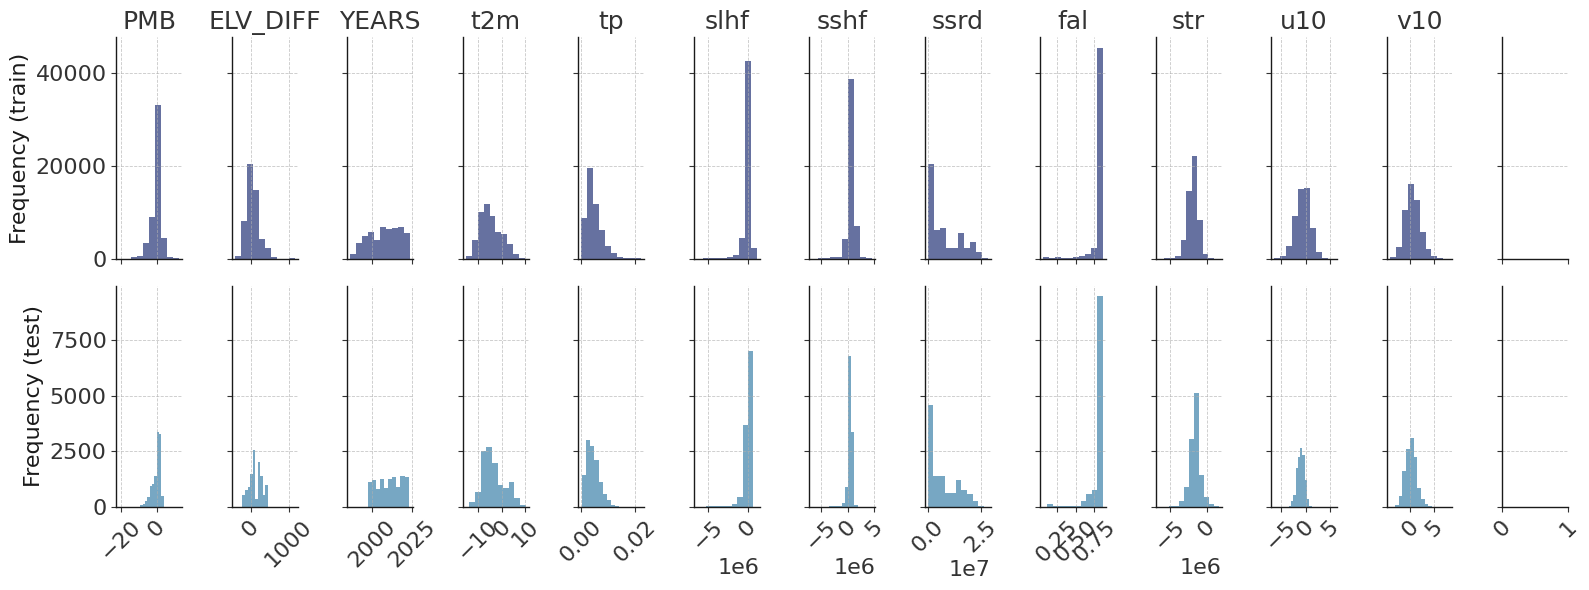

In [13]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

In [14]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

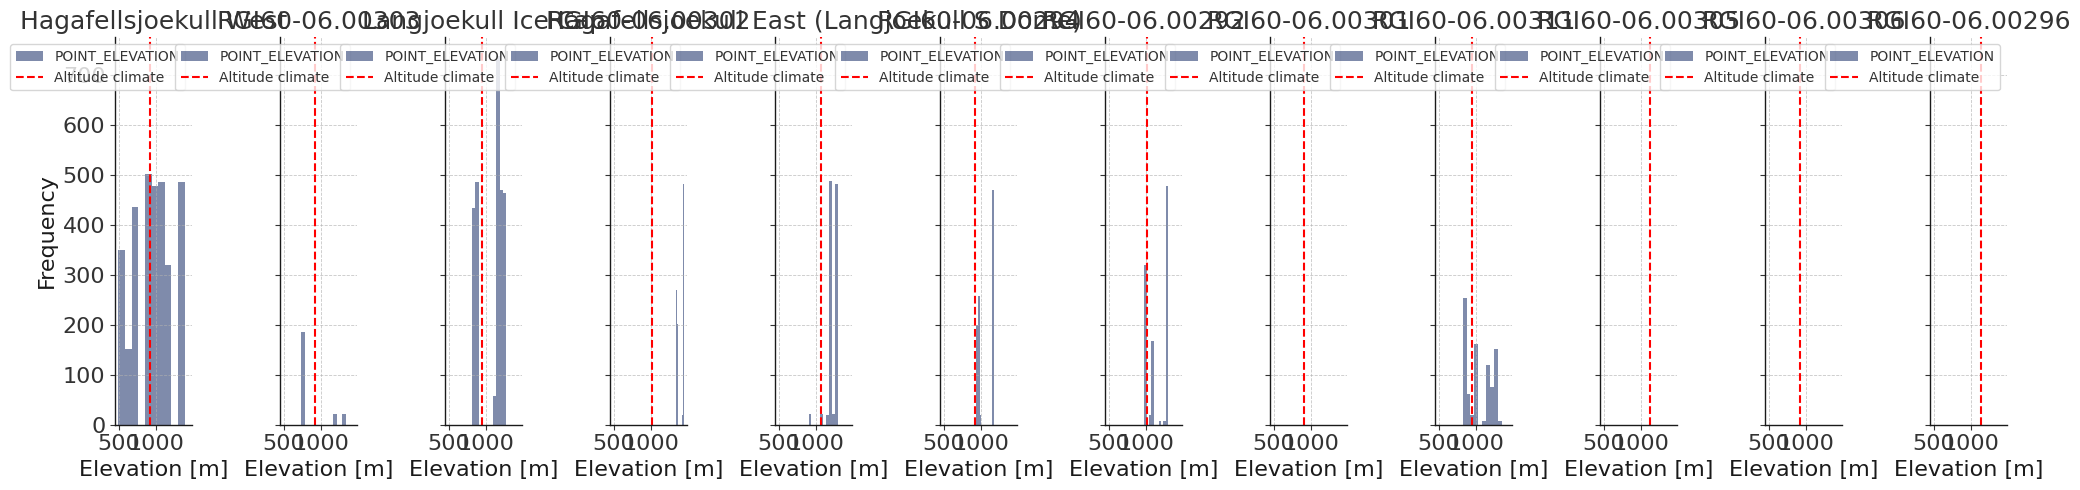

In [15]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

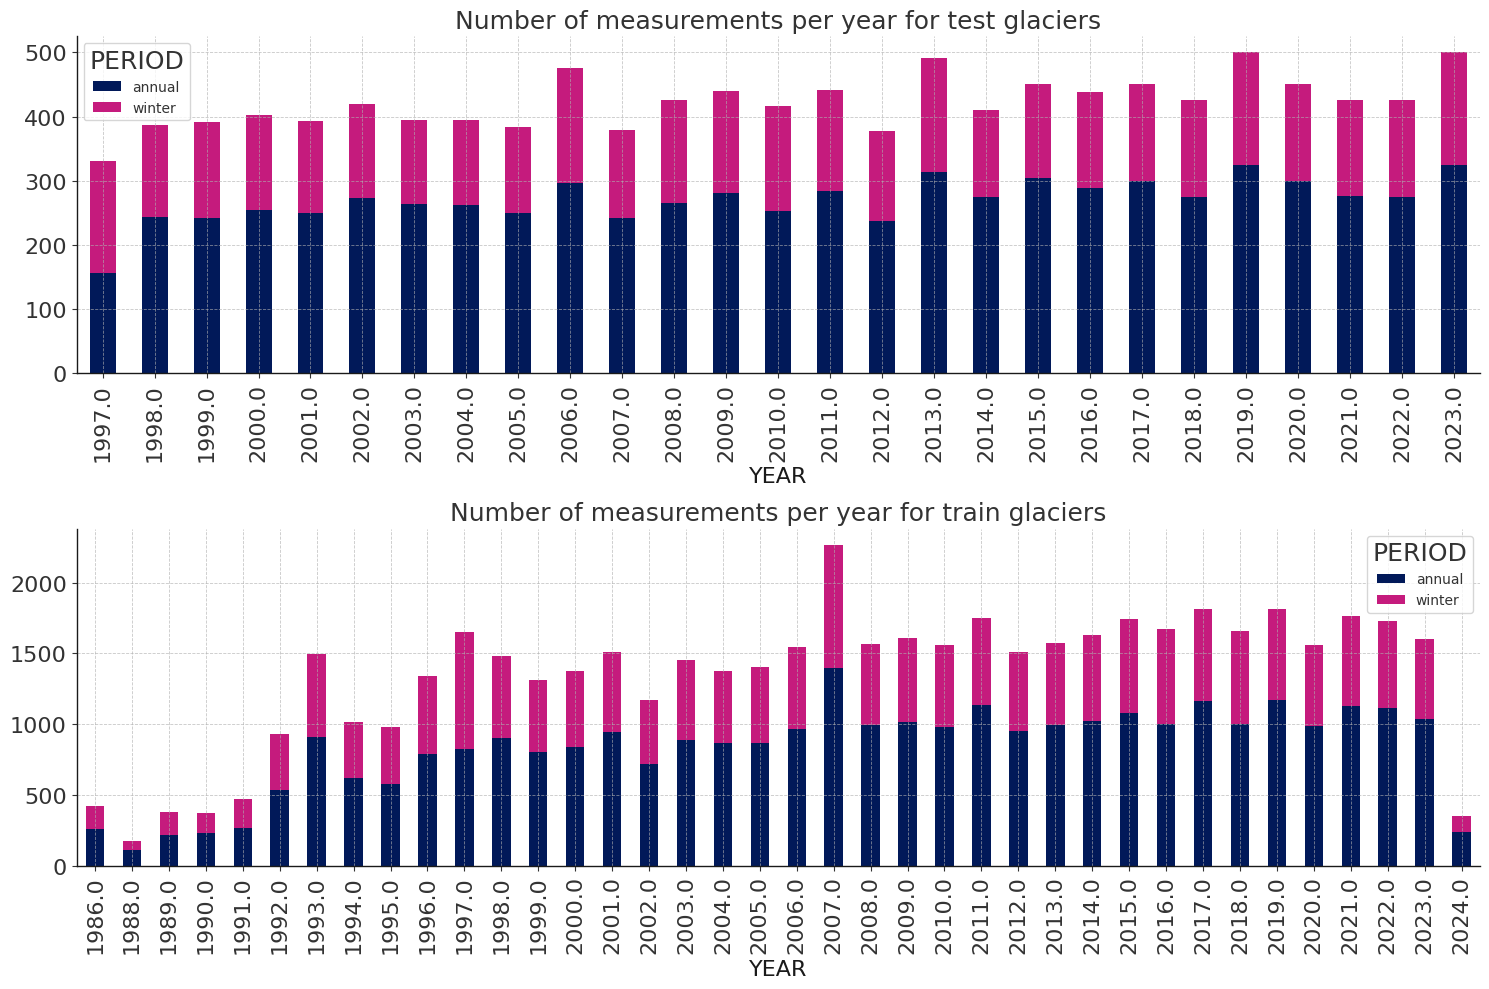

In [16]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

In [17]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    #"hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

### Grid search:

In [18]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_Iceland.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_Iceland.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (51008, 25)
Shape of testing dataset: (11417, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.6136214059281291
Shape of the test: (11417, 14)
Overall score: 1.1123751444467647
CPU times: user 2.52 s, sys: 44.2 ms, total: 2.57 s
Wall time: 141 ms


In [ ]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

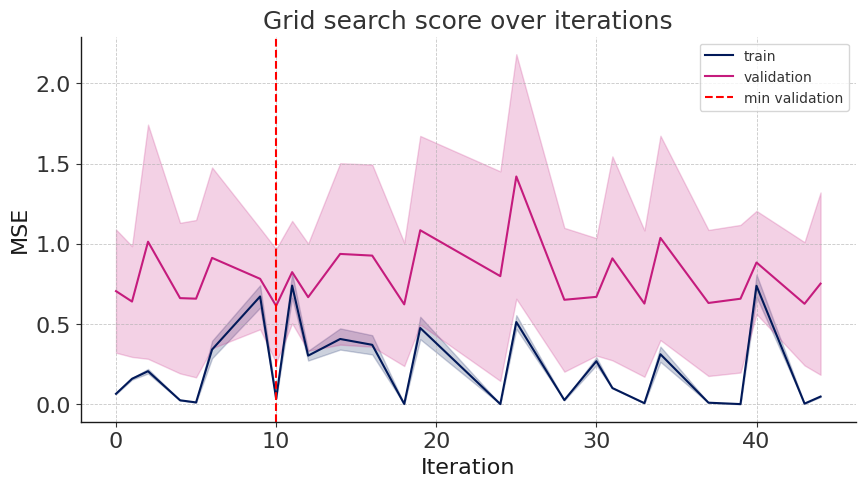

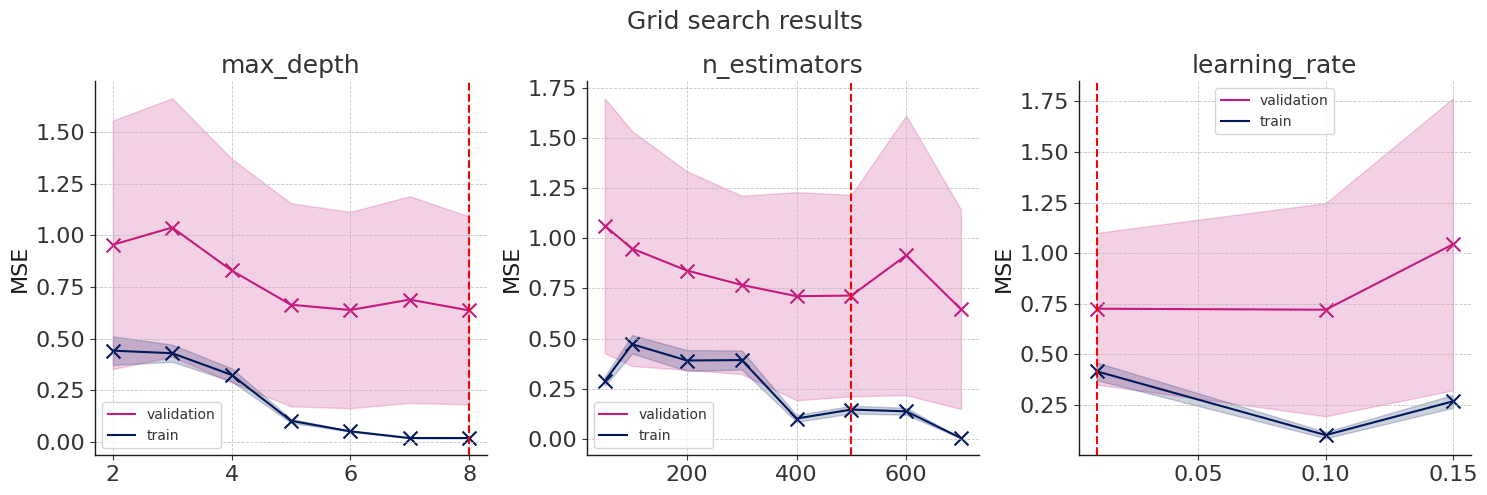

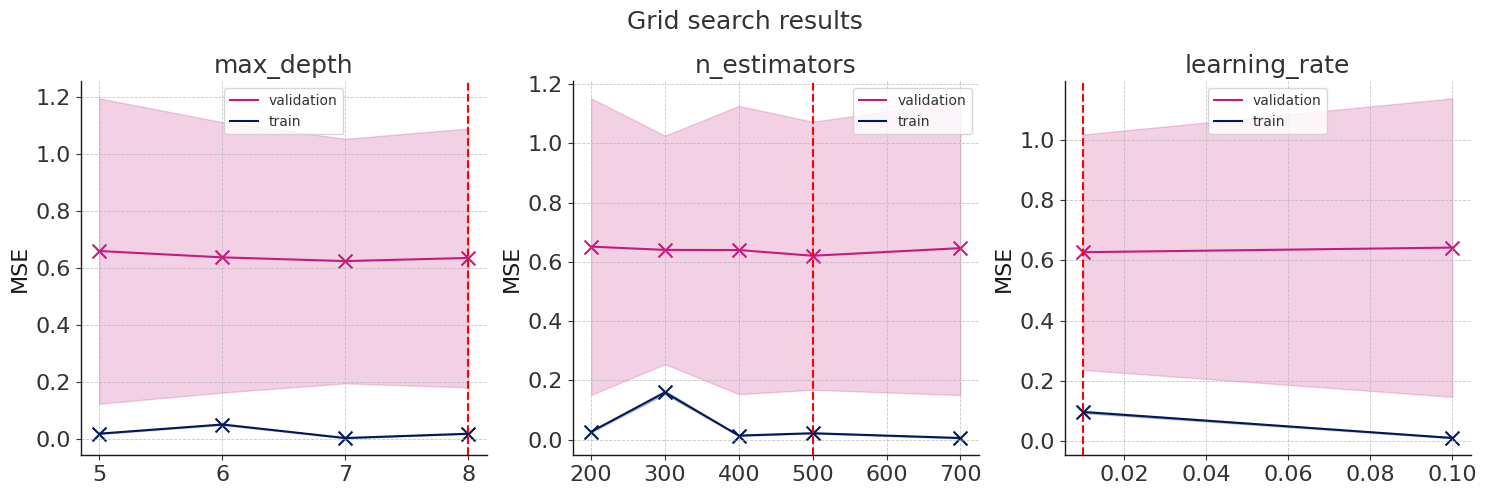

In [19]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

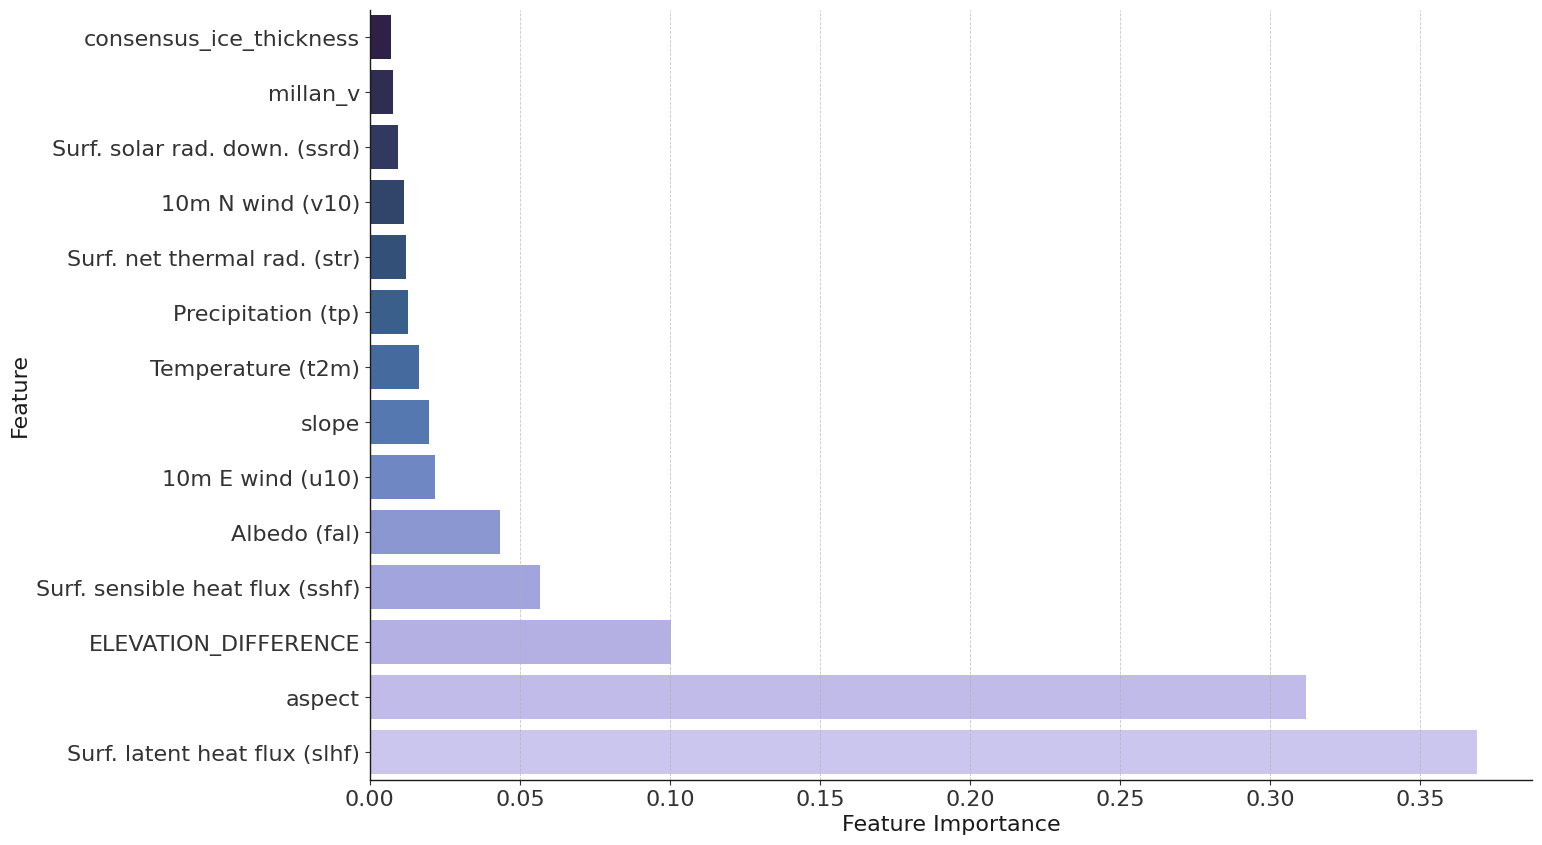

In [20]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

Shape of the test: (11417, 14)
{'Hagafellsjoekull West': '#a6cee3', 'RGI60-06.00303': '#1f78b4', 'Langjoekull Ice Cap': '#b2df8a', 'RGI60-06.00302': '#33a02c', 'Hagafellsjoekull East (Langjoekull S Dome)': '#fb9a99', 'RGI60-06.00294': '#e31a1c', 'RGI60-06.00292': '#fdbf6f', 'RGI60-06.00301': '#ff7f00', 'RGI60-06.00311': '#cab2d6', 'RGI60-06.00305': '#6a3d9a', 'RGI60-06.00306': '#ffff99', 'RGI60-06.00296': '#b15928'}


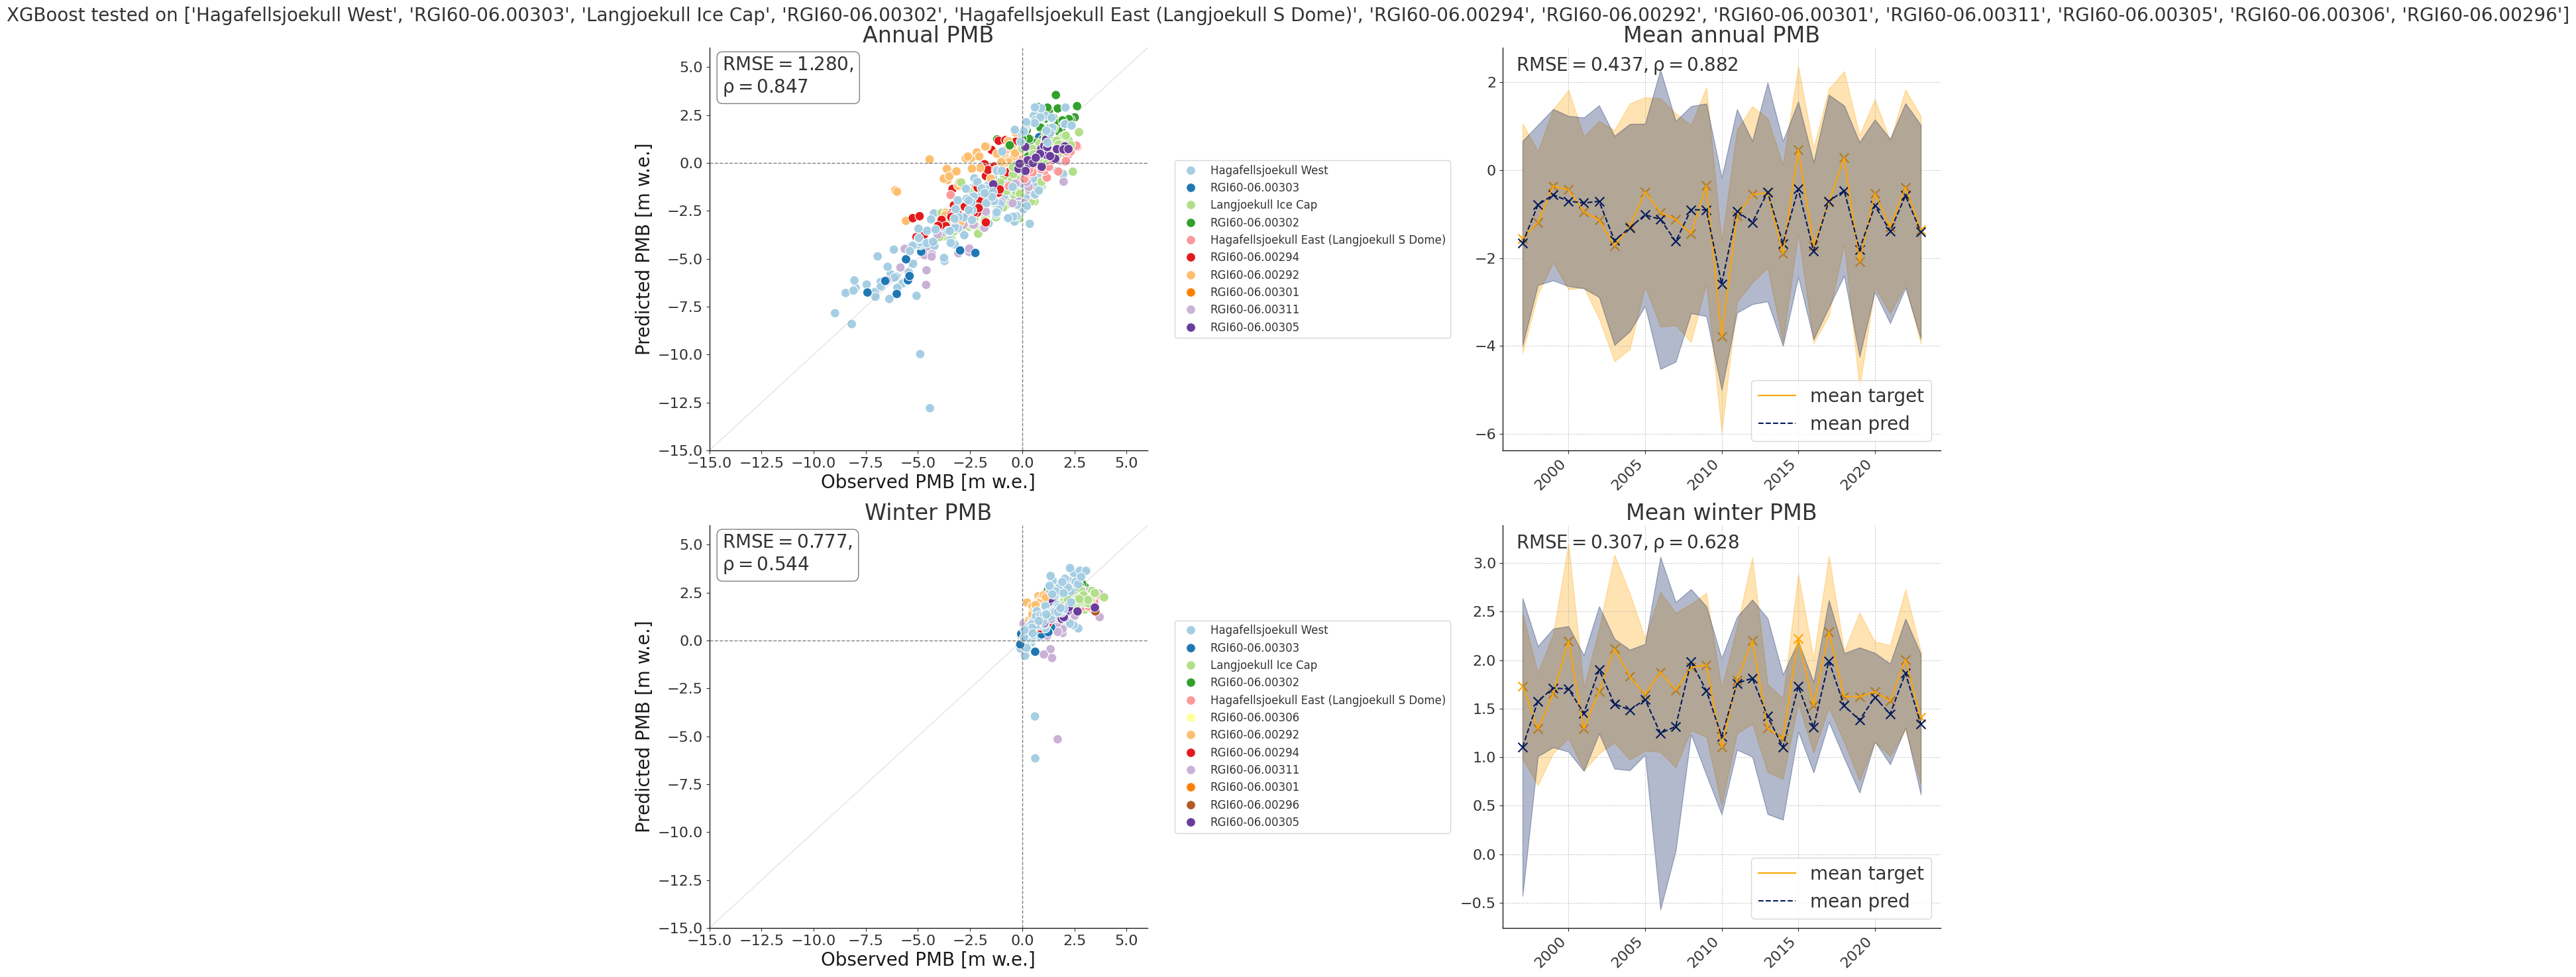

In [21]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

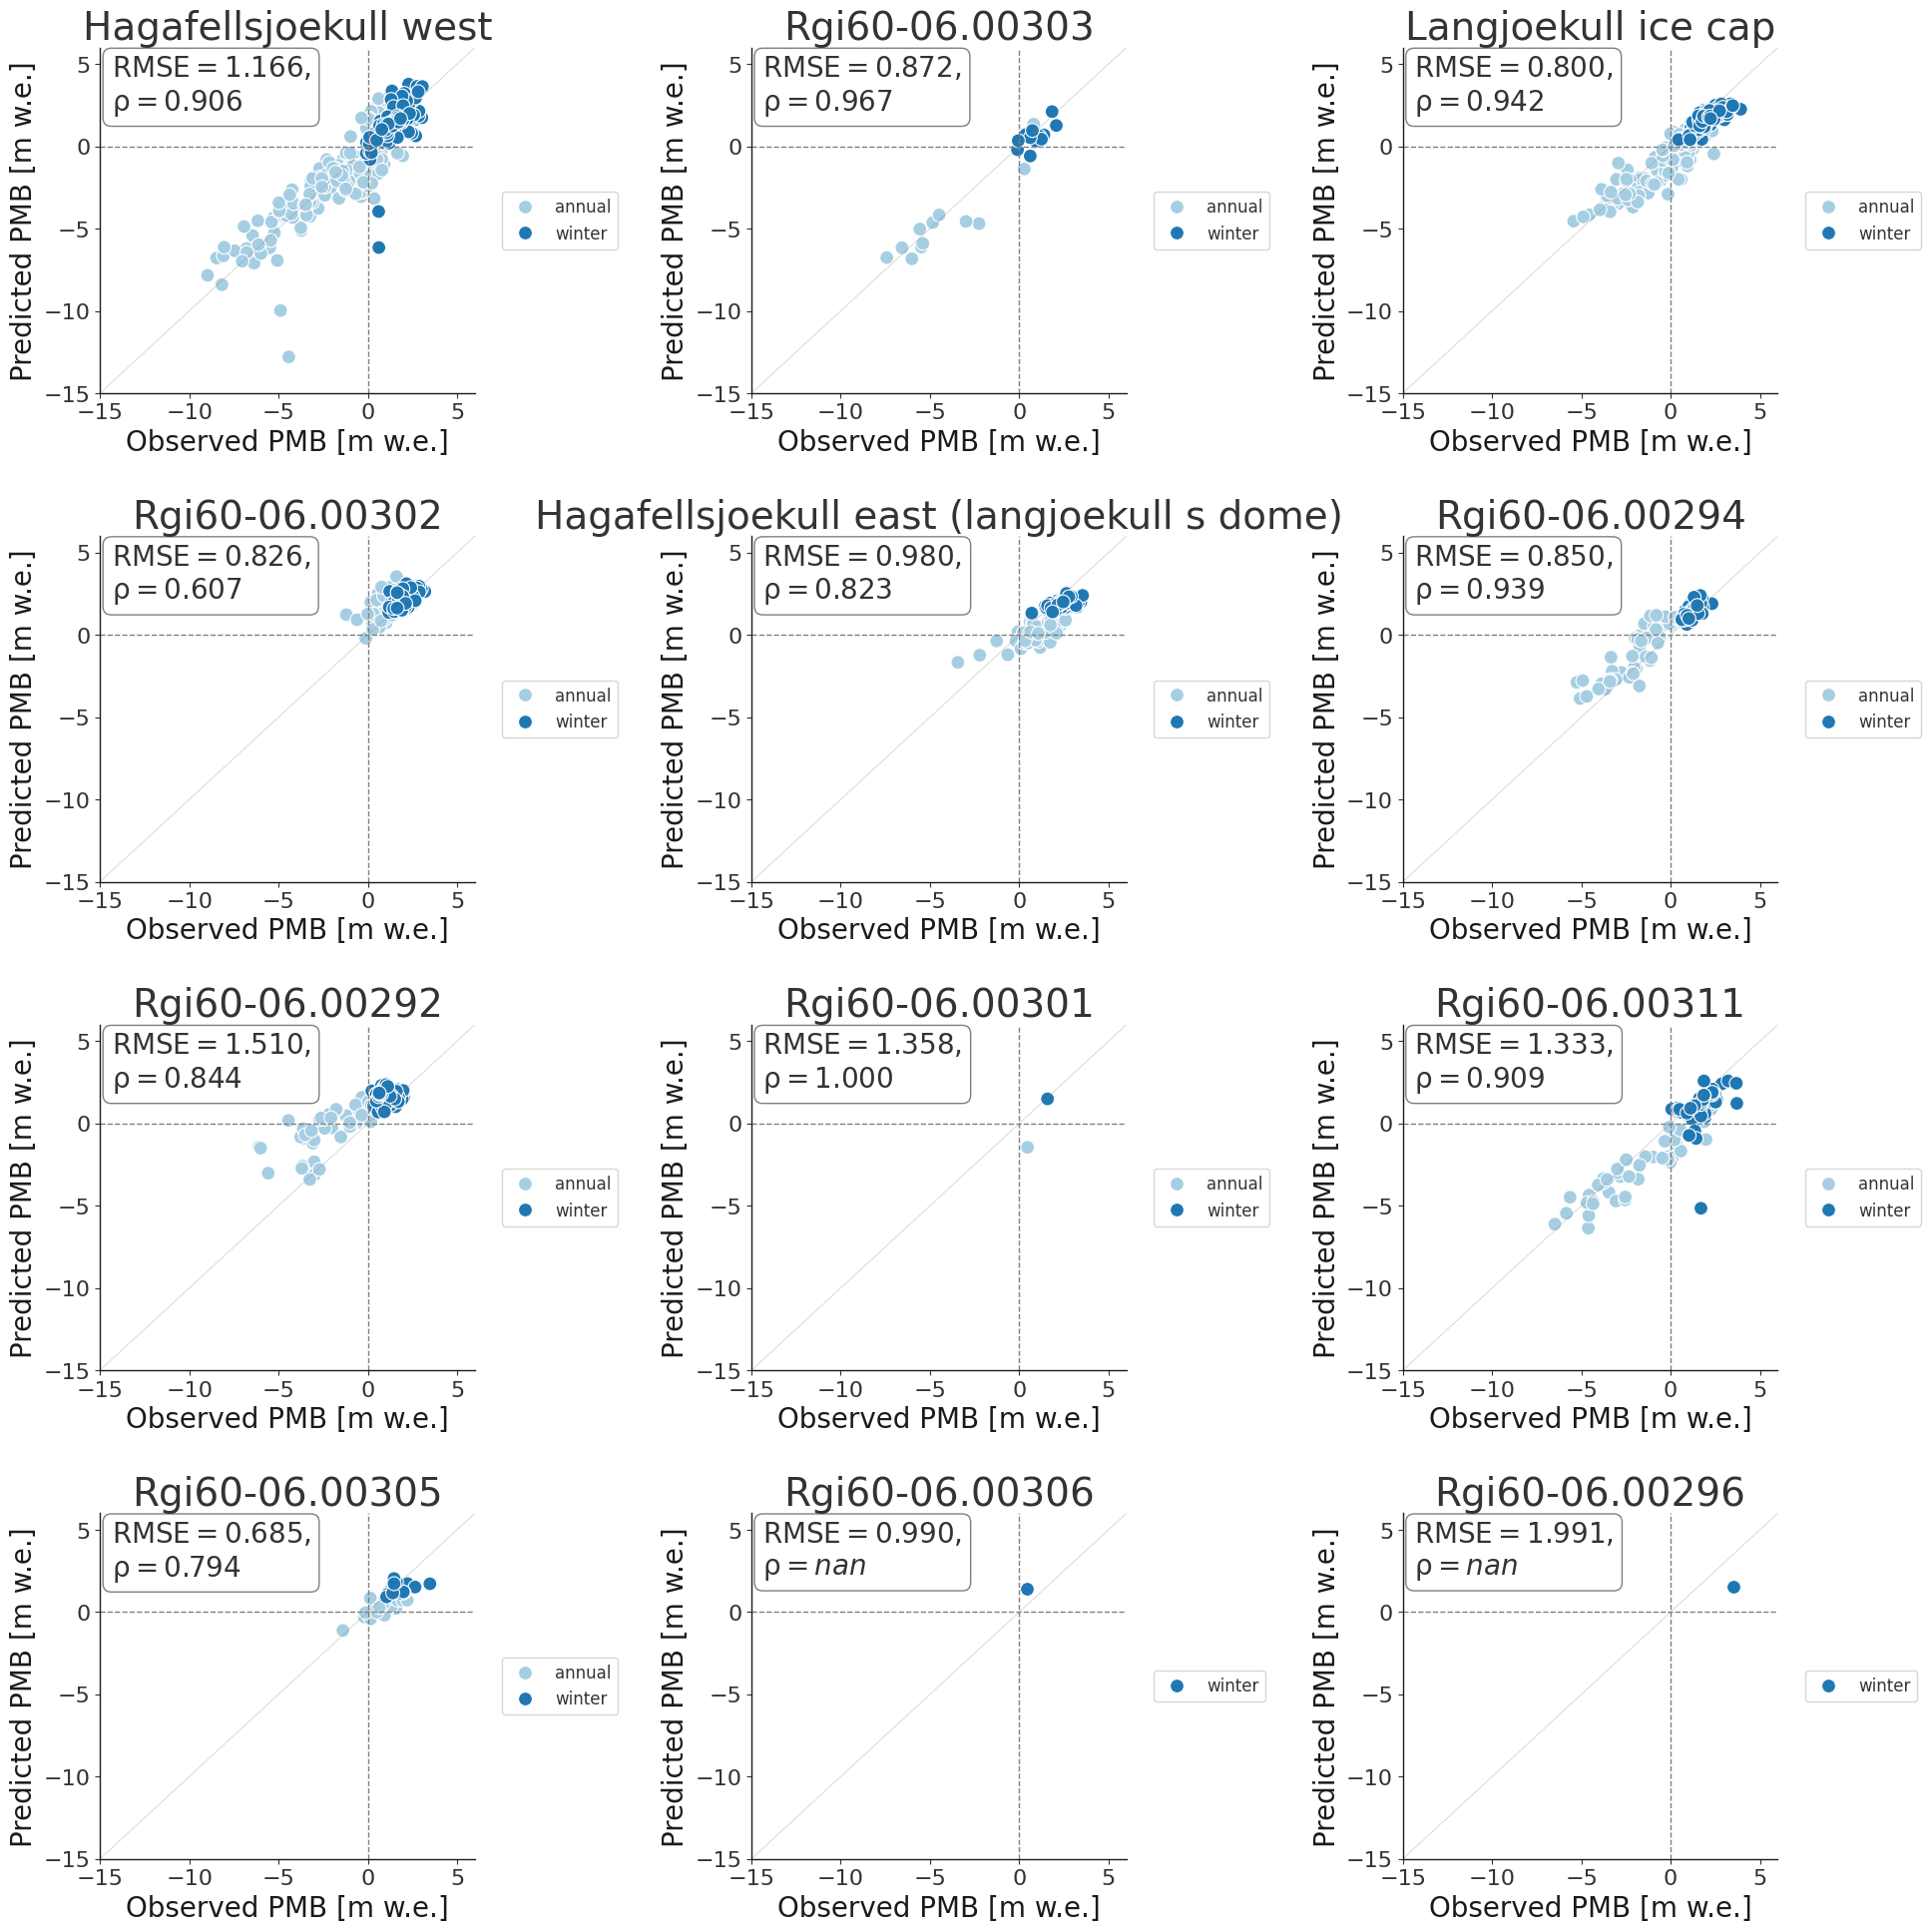

In [24]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

In [ ]:
display(data_monthly['GLACIER'].unique())

array(['GOLDBERG K.', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.',
       'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.', 'VENEDIGER K.',
       'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.', 'CAMPO SETT.', 'CARESER',
       'CARESER CENTRALE', 'CARESER OCCIDENTALE', 'CARESER ORIENTALE',
       'CIARDONEY', 'FONTANA BIANCA / WEISSBRUNNF.', 'GRAND ETRET',
       'LUNGA (VEDRETTA) / LANGENF.', 'LUPO',
       'MALAVALLE (VEDR. DI) / UEBELTALF.',
       'PENDENTE (VEDR.) / HANGENDERF.',
       'RIES OCC. (VEDR. DI) / RIESERF. WESTL.', 'SURETTA MERIDIONALE'],
      dtype=object)

#### Train CH Test ICE

###### Load CH galciers and merge with ICE

In [ ]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/GLAMOS/point/csv/CH_wgms_dataset_all.csv')
data_ICE = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_all_oggm.csv')
display(data_ICE)

display(data_CH.columns)

display(data_ICE.columns)

data_CH = data_CH.drop(['hugonnet_dhdt', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with ICE
data_ICE_CH = pd.concat([data_ICE, data_CH], axis=0).reset_index(drop=True)

display(data_ICE_CH.head(2))

display(len(data_ICE_CH['GLACIER'].unique()))

POINT_ELEVATION  POINT_LAT  POINT_LON  FROM_DATE   TO_DATE  \
0         1049.600000  64.790063 -18.595688   19880920  19890922   
1         1049.400000  64.790063 -18.595688   19890922  19900916   
2         1049.100000  64.790063 -18.595688   19900916  19910912   
3         1048.900000  64.790063 -18.595688   19910912  19920920   
4         1048.600000  64.790063 -18.595688   19920920  19930917   
...               ...        ...        ...        ...       ...   
6581      1697.000000  64.793858 -18.843883   20191106  20200429   
6582      1697.000000  64.793858 -18.843883   20201010  20210503   
6583      1697.000000  64.793858 -18.843883   20211021  20220427   
6584      1697.000000  64.793858 -18.843883   20221018  20230426   
6585      1692.968628  64.793858 -18.843883   20231024  20240501   

      POINT_BALANCE  PERIOD    YEAR           RGIId      aspect     slope  \
0              0.45  annual  1989.0  RGI60-06.00234  158.071560  2.508572   
1             -0.80  annual  1990.0  RGI60-06.00234  158.071560  2.508572   
2             -2.37  annual  1991.0  RGI60-06.00234  158.071560  2.508572   
3              0.65  annual  1992.0  RGI60-06.00234  158.071560  2.508572   
4             -0.06  annual  1993.0  RGI60-06.00234  158.071560  2.508572   
...             ...     ...     ...             ...         ...       ...   
6581           2.04  winter  2020.0  RGI60-06.00234  129.234952  3.695461   
6582           1.93  winter  2021.0  RGI60-06.00234  129.234952  3.695461   
6583           2.74  winter  2022.0  RGI60-06.00234  129.234952  3.695461   
6584           1.97  winter  2023.0  RGI60-06.00234  129.234952  3.695461   
6585           1.90  winter  2024.0  RGI60-06.00234  129.234952  3.695461   

             topo  consensus_ice_thickness   millan_v  \
0     1034.505493               270.877716  25.446609   
1     1034.505493               270.877716  25.446609   
2     1034.505493               270.877716  25.446609   
3     1034.505493               270.877716  25.446609   
4     1034.505493               270.877716  25.446609   
...           ...                      ...        ...   
6581  1692.968628               320.101654  48.503876   
6582  1692.968628               320.101654  48.503876   
6583  1692.968628               320.101654  48.503876   
6584  1692.968628               320.101654  48.503876   
6585  1692.968628               320.101654  48.503876   

                              GLACIER  \
0     Thjorsarjoekull (Hofsjoekull E)   
1     Thjorsarjoekull (Hofsjoekull E)   
2     Thjorsarjoekull (Hofsjoekull E)   
3     Thjorsarjoekull (Hofsjoekull E)   
4     Thjorsarjoekull (Hofsjoekull E)   
...                               ...   
6581  Thjorsarjoekull (Hofsjoekull E)   
6582  Thjorsarjoekull (Hofsjoekull E)   
6583  Thjorsarjoekull (Hofsjoekull E)   
6584  Thjorsarjoekull (Hofsjoekull E)   
6585  Thjorsarjoekull (Hofsjoekull E)   

                                               POINT_ID  
0     Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...  
1     Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...  
2     Thjorsarjoekull (Hofsjoekull E)_1991.0_annual_...  
3     Thjorsarjoekull (Hofsjoekull E)_1992.0_annual_...  
4     Thjorsarjoekull (Hofsjoekull E)_1993.0_annual_...  
...                                                 ...  
6581  Thjorsarjoekull (Hofsjoekull E)_2020.0_winter_...  
6582  Thjorsarjoekull (Hofsjoekull E)_2021.0_winter_...  
6583  Thjorsarjoekull (Hofsjoekull E)_2022.0_winter_...  
6584  Thjorsarjoekull (Hofsjoekull E)_2023.0_winter_...  
6585  Thjorsarjoekull (Hofsjoekull E)_2024.0_winter_...  

[6586 rows x 16 columns]

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId', 'aspect', 'slope', 'topo',
       'consensus_ice_thickness', 'millan_v', 'GLACIER', 'POINT_ID'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

POINT_ELEVATION  POINT_LAT  POINT_LON  FROM_DATE   TO_DATE  POINT_BALANCE  \
0           1049.6  64.790063 -18.595688   19880920  19890922           0.45   
1           1049.4  64.790063 -18.595688   19890922  19900916          -0.80   

   PERIOD    YEAR           RGIId     aspect     slope         topo  \
0  annual  1989.0  RGI60-06.00234  158.07156  2.508572  1034.505493   
1  annual  1990.0  RGI60-06.00234  158.07156  2.508572  1034.505493   

   consensus_ice_thickness   millan_v                          GLACIER  \
0               270.877716  25.446609  Thjorsarjoekull (Hofsjoekull E)   
1               270.877716  25.446609  Thjorsarjoekull (Hofsjoekull E)   

                                            POINT_ID  
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...  
1  Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...

88

In [28]:
display(data_ICE_CH.head(2))

POINT_ELEVATION  POINT_LAT  POINT_LON  FROM_DATE   TO_DATE  POINT_BALANCE  \
0           1049.6  64.790063 -18.595688   19880920  19890922           0.45   
1           1049.4  64.790063 -18.595688   19890922  19900916          -0.80   

   PERIOD    YEAR           RGIId     aspect     slope         topo  \
0  annual  1989.0  RGI60-06.00234  158.07156  2.508572  1034.505493   
1  annual  1990.0  RGI60-06.00234  158.07156  2.508572  1034.505493   

   consensus_ice_thickness   millan_v                          GLACIER  \
0               270.877716  25.446609  Thjorsarjoekull (Hofsjoekull E)   
1               270.877716  25.446609  Thjorsarjoekull (Hofsjoekull E)   

                                            POINT_ID  
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...  
1  Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...

In [29]:
display(data_ICE_CH['PERIOD'].unique())

array(['annual', 'winter'], dtype=object)

In [31]:
data_CH_ICE_test = data_ICE_CH.copy()

display(data_CH_ICE_test.shape)
display(data_CH_ICE_test.head(2))

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_WGMS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure.nc'
    #'radiation_save_path': path_pcsr + 'zarr/'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_ICE_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_ICE_wgms_dataset_monthly_full.csv')
data_monthly_CH_ICE = dataloader_gl.data

display(data_monthly_CH_ICE.head(2))

(39944, 16)

POINT_ELEVATION  POINT_LAT  POINT_LON  FROM_DATE   TO_DATE  POINT_BALANCE  \
0           1049.6  64.790063 -18.595688   19880920  19890922           0.45   
1           1049.4  64.790063 -18.595688   19890922  19900916          -0.80   

   PERIOD    YEAR           RGIId     aspect     slope         topo  \
0  annual  1989.0  RGI60-06.00234  158.07156  2.508572  1034.505493   
1  annual  1990.0  RGI60-06.00234  158.07156  2.508572  1034.505493   

   consensus_ice_thickness   millan_v                          GLACIER  \
0               270.877716  25.446609  Thjorsarjoekull (Hofsjoekull E)   
1               270.877716  25.446609  Thjorsarjoekull (Hofsjoekull E)   

                                            POINT_ID  
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...  
1  Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...

2025-05-27 07:49:50,171 - INFO - Number of annual and seasonal samples: 39944
2025-05-27 07:49:50,175 - INFO - Running on 88 glaciers:
['Thjorsarjoekull (Hofsjoekull E)' 'Sidujoekull/Skaftarjoekull'
 'Breidamerkurjoekull' 'Dyngjujoekull' 'RGI60-06.00328' 'Tungnaarjoekull'
 'Hagafellsjoekull West' 'Eyjabakkajoekull' 'RGI60-06.00303'
 'Langjoekull Ice Cap' 'Koeldukvislarjoekull' 'Oeldufellsjoekull'
 'Skeidararjoekull' 'Slettjoekull West' 'RGI60-06.00466' 'RGI60-06.00411'
 'RGI60-06.00302' 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238' 'RGI60-06.00320'
 'Sylgjujoekull' 'Hagafellsjoekull East (Langjoekull S Dome)'
 'RGI60-06.00342' 'RGI60-06.00480' 'RGI60-06.00465' 'RGI60-06.00294'
 'RGI60-06.00292' 'RGI60-06.00232' 'RGI60-06.00478' 'Mulajoekull'
 'RGI60-06.00301' 'RGI60-06.00413' 'RGI60-06.00311' 'RGI60-06.00350'
 'RGI60-06.00476' 'RGI60-06.00228' 'RGI60-06.00409' 'RGI60-06.00349'
 'RGI60-06.00422' 'RGI60-06.00305' 'RGI60-06.00425' 'R

2025-05-27 07:49:50,588 - INFO - Number of winter and annual samples: 39944
2025-05-27 07:49:50,593 - INFO - Number of annual samples: 10511
2025-05-27 07:49:50,599 - INFO - Number of winter samples: 29433
2025-05-27 07:49:50,600 - INFO - Adding climate features...
2025-05-27 07:50:13,864 - INFO - Converting to monthly resolution...
2025-05-27 07:51:43,526 - INFO - Number of monthly rows: 353107
2025-05-27 07:51:43,527 - INFO - Columns in the dataset: Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'aspect', 'slope',
       'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf',
       'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')
2025-05-27 07:51:50,223 - INFO - Processed data saved to: /home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/CH_ICE_wgms_dataset_monthly_full.csv


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  1989.0 -18.595688  64.790063           0.45       1094.738918   
1  1989.0 -18.595688  64.790063           0.45       1094.738918   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            -45.138918           1049.6  RGI60-06.00234   
1            -45.138918           1049.6  RGI60-06.00234   

                                            POINT_ID  ID  ...   millan_v  \
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   
1  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   

        t2m        tp      slhf      sshf       ssrd      fal        str  \
0 -4.787933  0.003747  198886.0  590722.0  3990646.0  0.84564 -1779436.0   
1 -5.262054  0.003766  306376.0  576896.0   883468.0  0.84690 -1458576.0   

        u10       v10  
0 -0.590102  0.603381  
1  0.129348  2.214950  

[2 rows x 27 columns]

In [33]:
test_glaciers = list(data_ICE['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
#train_glaciers = list(data_CH['GLACIER'].unique())
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Size of test data: 62425
Size of train data: 290682
Percentage of test size: 21.48%
Train:
Number of winter and annual samples: 290682
Number of annual samples: 87440
Number of winter samples: 203242
Test:
Number of winter and annual samples: 62425
Number of annual samples: 38826
Number of winter samples: 23599
Total:
Number of monthly rows: 353107
Number of annual rows: 126266
Number of winter rows: 226841


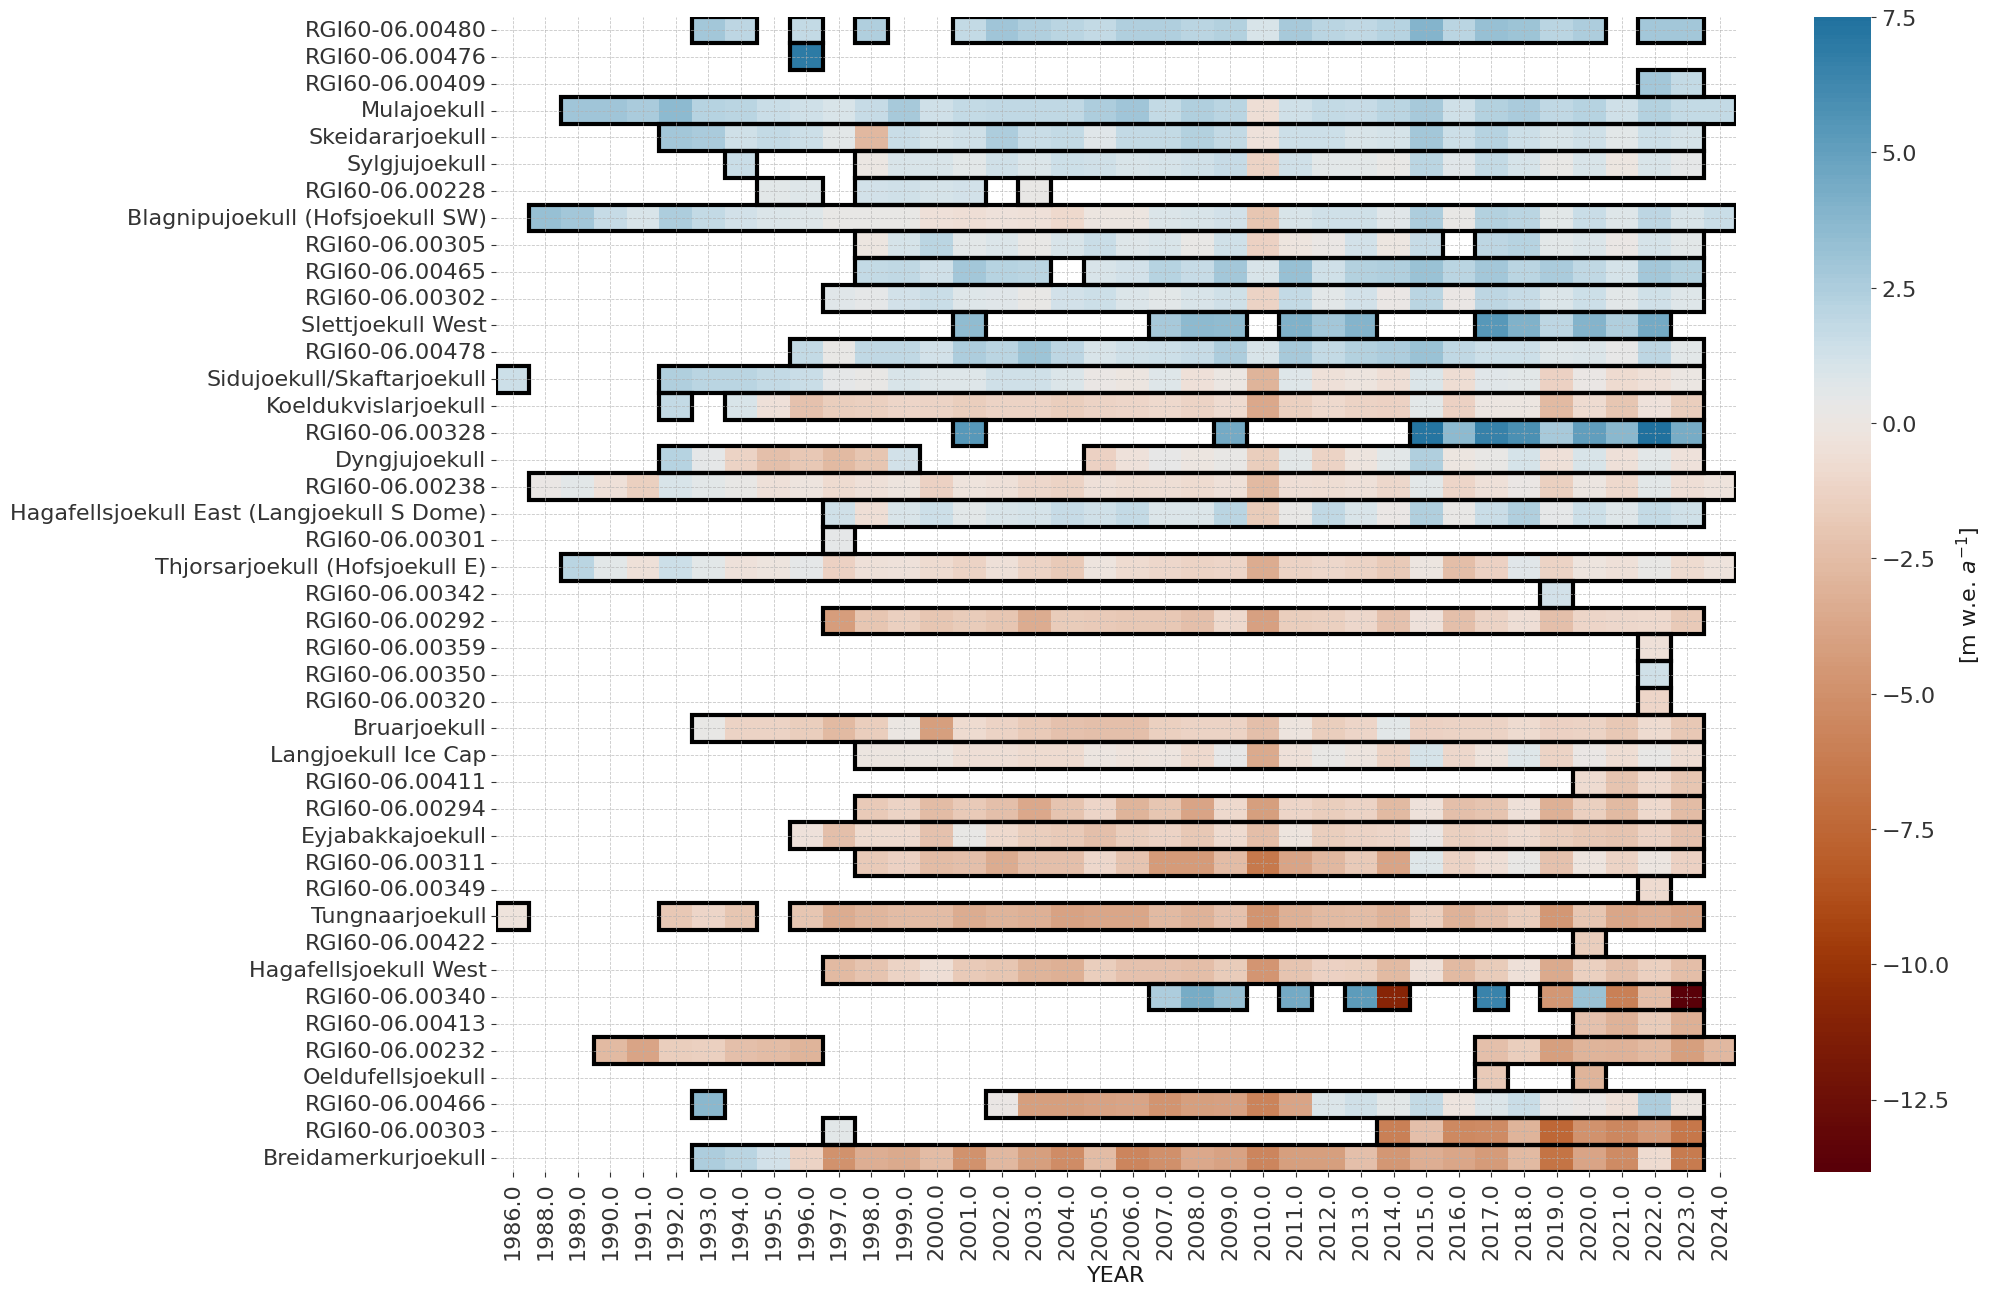

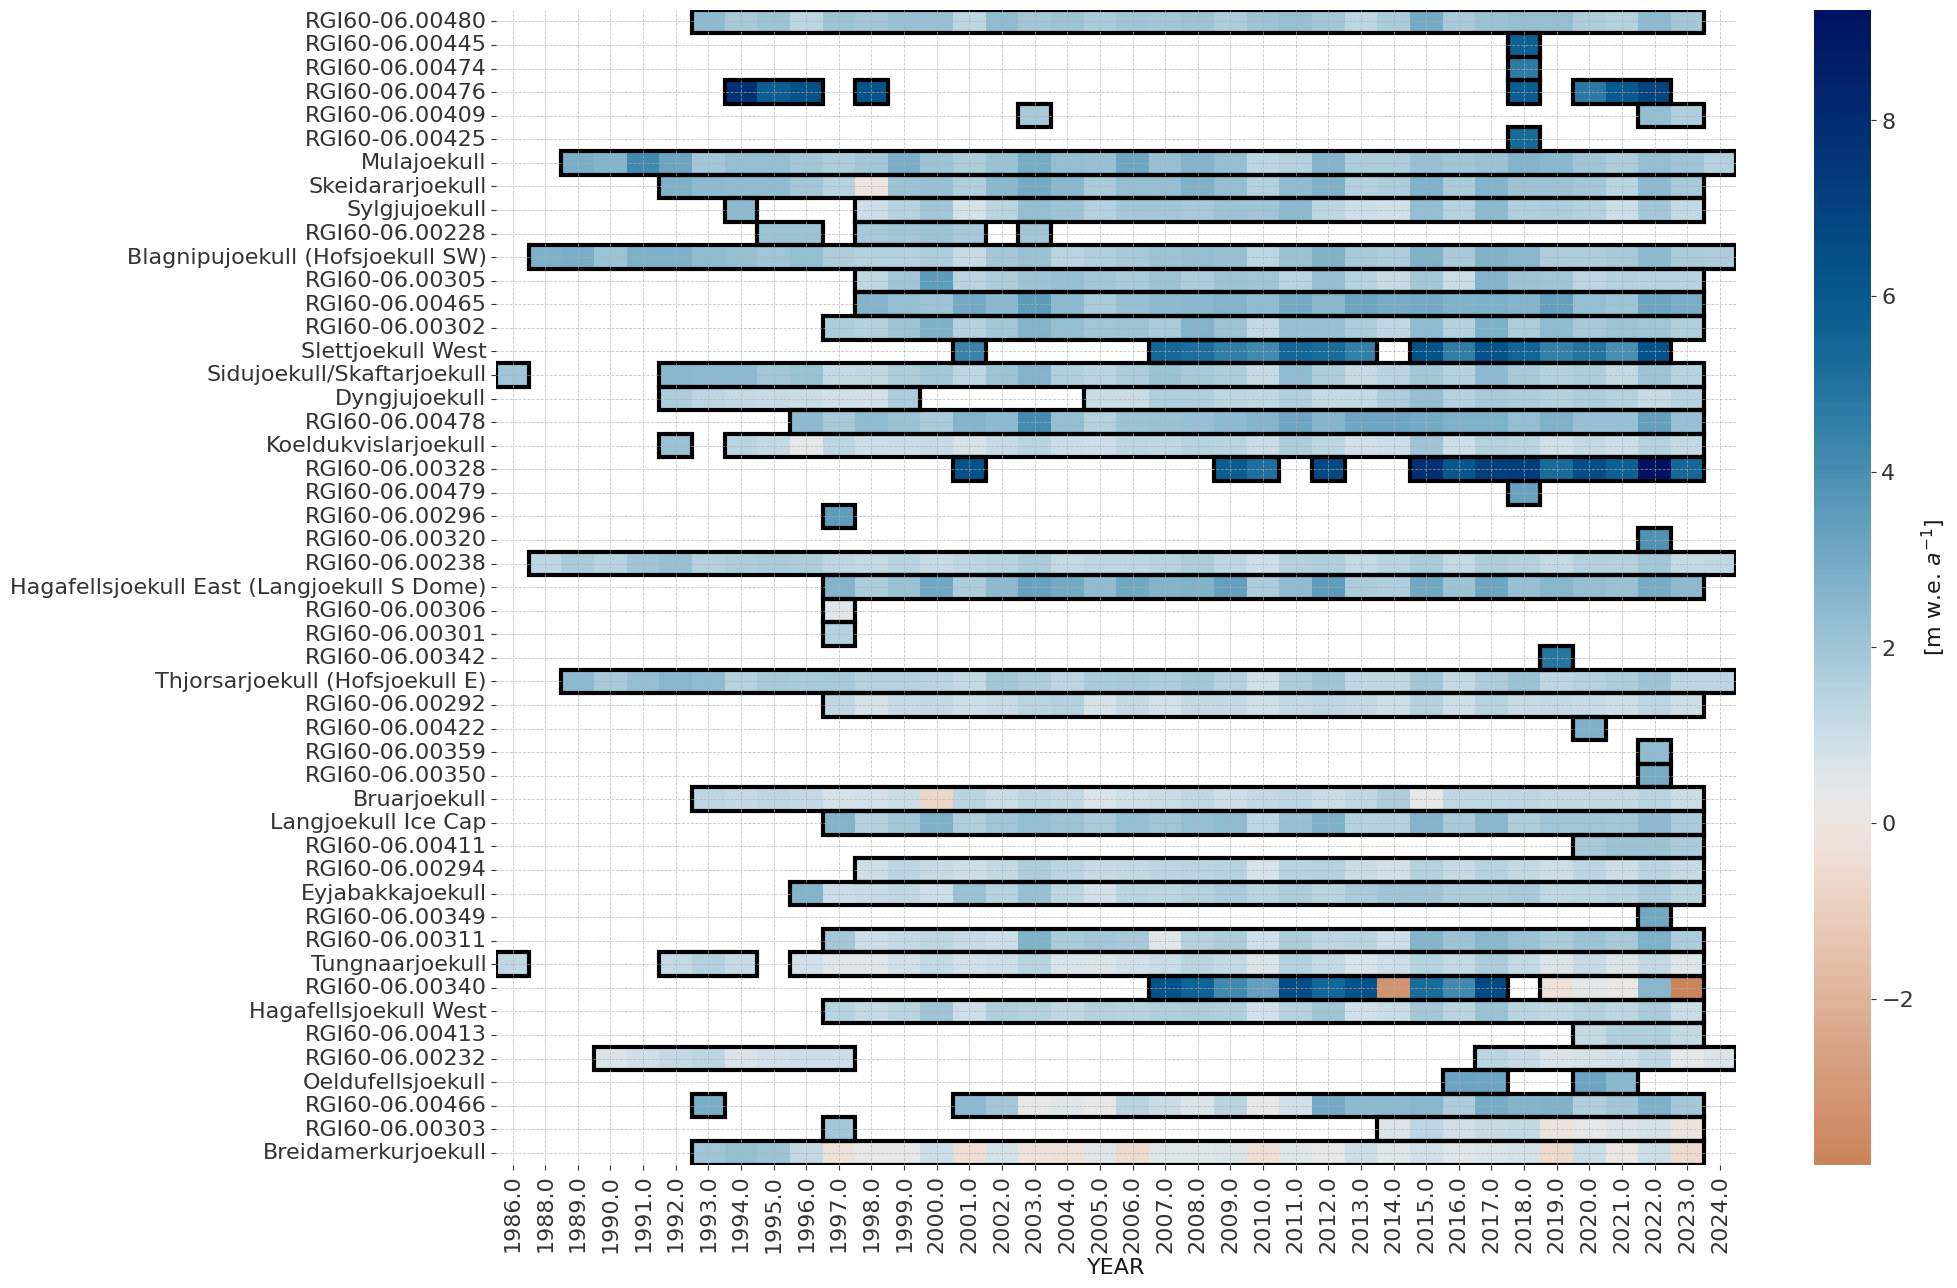

In [34]:
plotHeatmap(test_glaciers, data_monthly, period='annual')

plotHeatmap(test_glaciers, data_monthly, period='winter')

Test glaciers: (49) ['Thjorsarjoekull (Hofsjoekull E)' 'Sidujoekull/Skaftarjoekull'
 'Breidamerkurjoekull' 'Dyngjujoekull' 'RGI60-06.00328' 'Tungnaarjoekull'
 'Hagafellsjoekull West' 'Eyjabakkajoekull' 'RGI60-06.00303'
 'Langjoekull Ice Cap' 'Koeldukvislarjoekull' 'Oeldufellsjoekull'
 'Skeidararjoekull' 'Slettjoekull West' 'RGI60-06.00466' 'RGI60-06.00411'
 'RGI60-06.00302' 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238' 'RGI60-06.00320'
 'Sylgjujoekull' 'Hagafellsjoekull East (Langjoekull S Dome)'
 'RGI60-06.00342' 'RGI60-06.00480' 'RGI60-06.00465' 'RGI60-06.00294'
 'RGI60-06.00292' 'RGI60-06.00232' 'RGI60-06.00478' 'Mulajoekull'
 'RGI60-06.00301' 'RGI60-06.00413' 'RGI60-06.00311' 'RGI60-06.00350'
 'RGI60-06.00476' 'RGI60-06.00228' 'RGI60-06.00409' 'RGI60-06.00349'
 'RGI60-06.00422' 'RGI60-06.00305' 'RGI60-06.00425' 'RGI60-06.00306'
 'RGI60-06.00479' 'RGI60-06.00296' 'RGI60-06.00445' 'RGI60-06.00474']
Percentage of test size: 21.48

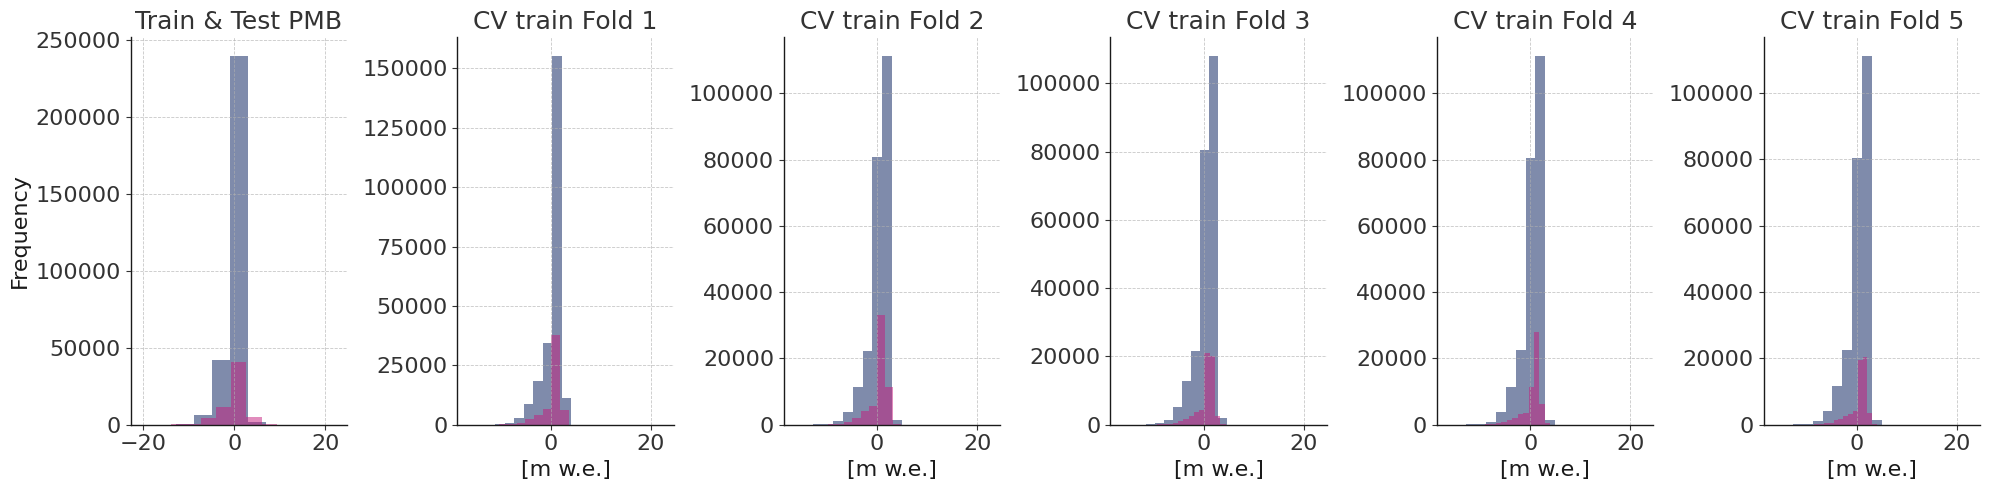

In [35]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

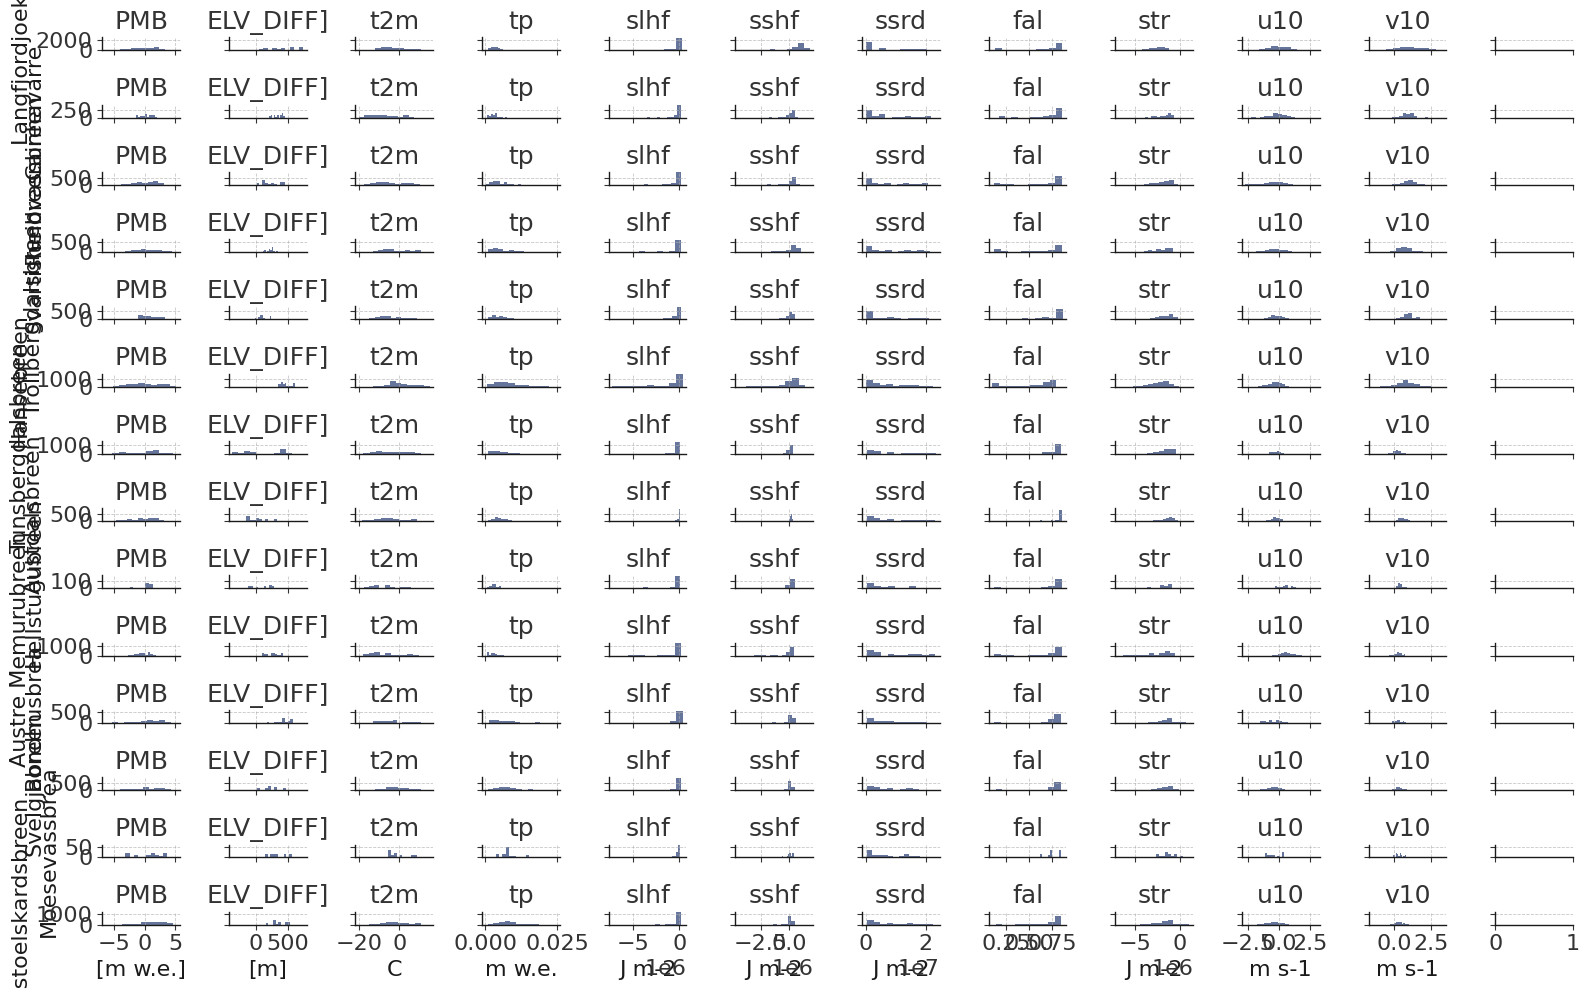

In [19]:
# This cells takes over 10 minuts to execute

# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

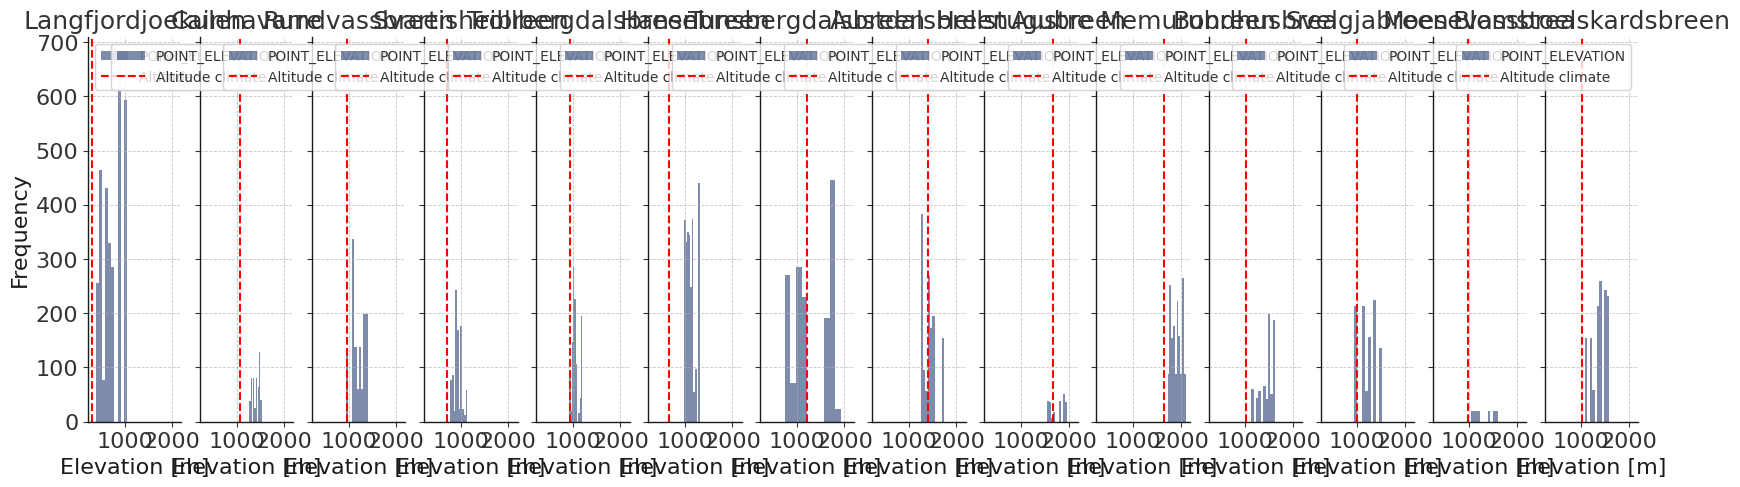

In [20]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

In [36]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

#### XGBoost

In [38]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    #"hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

#### Grid Search

In [39]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = True
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'CH_train_ICE_test.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'CH_train_ICE_test.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (290682, 25)
Shape of testing dataset: (62425, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'consensus_ice_thickness', 'millan_v']
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [07:57:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [07:57:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [07:57:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [07:57:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.

Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.19564066187781454
Shape of the test: (62425, 14)
Overall score: 4.762336860154793
CPU times: user 8min 31s, sys: 5.29 s, total: 8min 37s
Wall time: 37min 11s


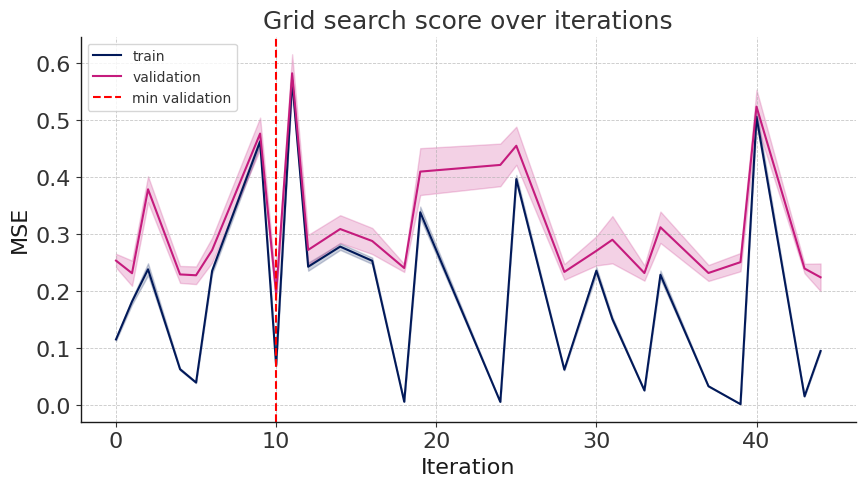

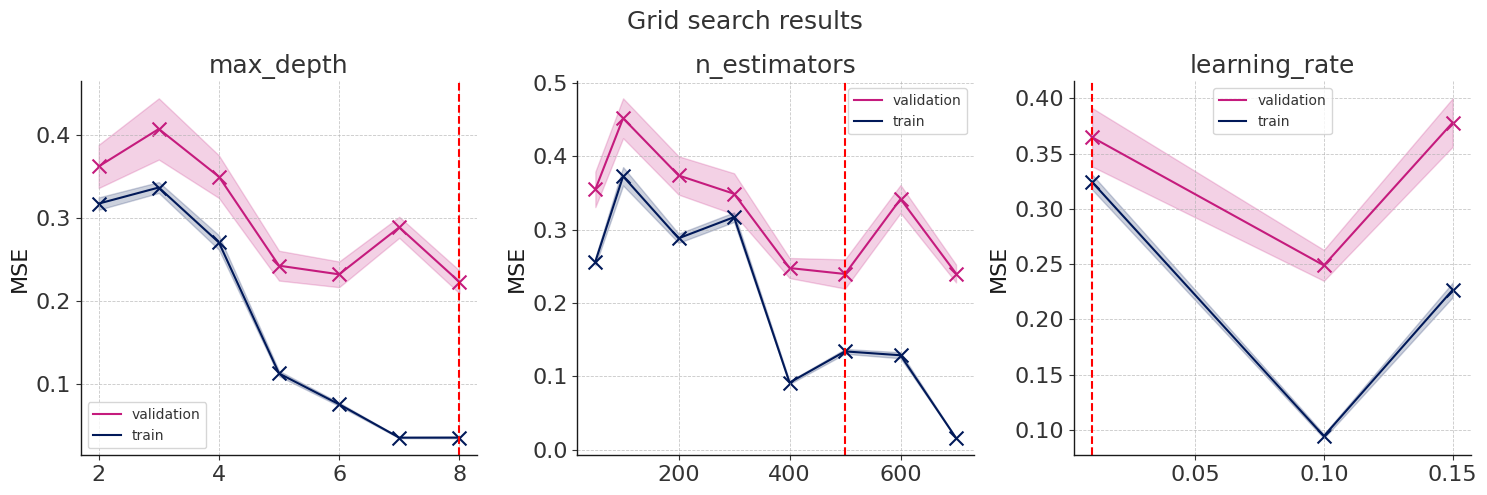

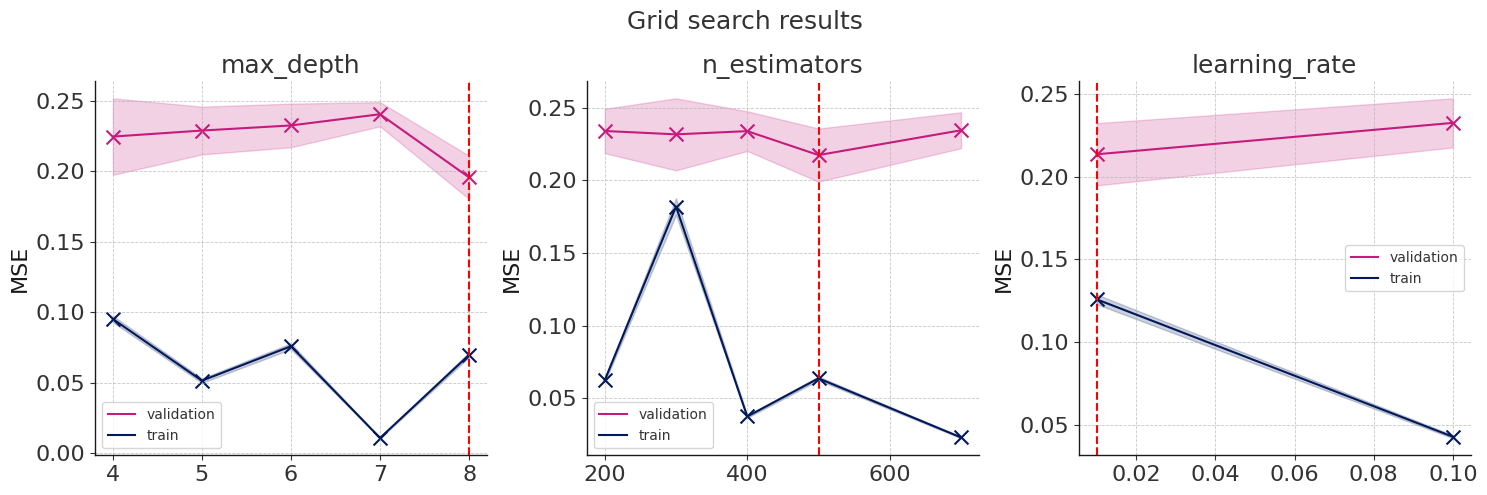

In [40]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

In [41]:
FIPlot(best_estimator, feature_columns, vois_climate)

In [42]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost trained on CH tested on ICE', fontsize=20)
plt.tight_layout()

PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

Shape of the test: (62425, 14)
{'Thjorsarjoekull (Hofsjoekull E)': '#a6cee3', 'Sidujoekull/Skaftarjoekull': '#1f78b4', 'Breidamerkurjoekull': '#b2df8a', 'Dyngjujoekull': '#33a02c', 'RGI60-06.00328': '#fb9a99', 'Tungnaarjoekull': '#e31a1c', 'Hagafellsjoekull West': '#fdbf6f', 'Eyjabakkajoekull': '#ff7f00', 'RGI60-06.00303': '#cab2d6', 'Langjoekull Ice Cap': '#6a3d9a', 'Koeldukvislarjoekull': '#ffff99', 'Oeldufellsjoekull': '#b15928', 'Skeidararjoekull': '#8dd3c7', 'Slettjoekull West': '#ffffb3', 'RGI60-06.00466': '#bebada', 'RGI60-06.00411': '#fb8072', 'RGI60-06.00302': '#80b1d3', 'RGI60-06.00359': '#fdb462', 'RGI60-06.00340': '#b3de69', 'Bruarjoekull': '#fccde5', 'Blagnipujoekull (Hofsjoekull SW)': '#d9d9d9', 'RGI60-06.00238': '#bc80bd', 'RGI60-06.00320': '#ccebc5', 'Sylgjujoekull': '#ffed6f', 'Hagafellsjoekull East (Langjoekull S Dome)': '#66c2a5', 'RGI60-06.00342': '#fc8d62', 'RGI60-06.00480': '#8da0cb', 'RGI60-06.00465': '#e78ac3', 'RGI60-06.00294': '#a6d854', 'RGI60-06.00292': '#ff

ValueError: The palette dictionary is missing keys: {'RGI60-06.00479', 'RGI60-06.00296', 'RGI60-06.00306', 'RGI60-06.00474', 'RGI60-06.00445'}

In [43]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH train ICE test')

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
# feature_columns = ['ELEVATION_DIFFERENCE'
#                    ] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

In [ ]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

In [ ]:
FIPlot(custom_model, feature_columns, vois_climate)

## Extrapolate in space


### Geodetic MB:

In [ ]:
geodetic_mb = get_geodetic_MB()

# filter to glaciers with potential clear sky radiation data
geodetic_mb = geodetic_mb[geodetic_mb.glacier_name.isin(glDirect)]

# get years per glacier
years_start_per_gl = geodetic_mb.groupby(
    'glacier_name')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodetic_mb.groupby('glacier_name')['Aend'].unique().apply(
    list).to_dict()

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)

# Iterate through the DataFrame rows
for _, row in geodetic_mb.iterrows():
    glacier_name = row['glacier_name']
    start_year = row['Astart']
    end_year = row['Aend']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    # Only if period is longer than 5 years
    if end_year - start_year >= 5:
        periods_per_glacier[glacier_name].append((start_year, end_year))
        geoMB_per_glacier[glacier_name].append(geoMB)

# sort by glacier_list
periods_per_glacier = dict(sorted(periods_per_glacier.items()))
geoMB_per_glacier = dict(sorted(geoMB_per_glacier.items()))

### Glacier wide MB: 
Compute 2D fields.

In [ ]:
glDirect = [
    re.search(r'xr_direct_(.*?).zarr', f).group(1)
    for f in os.listdir(path_pcsr + 'zarr/')
]
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
glacier_list = list(data_glamos.GLACIER.unique())
print('Number of glaciers with pcsr:', len(glacier_list))

# satellite_glaciers = [
#     'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
#     'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
#     'schwarzbach', 'schwarzberg'
# ]

geodetic_glaciers = periods_per_glacier.keys()
print('Number of glaciers with geodetic MB:', len(geodetic_glaciers))

# Intersection of both
common_glaciers = list(set(geodetic_glaciers) & set(glacier_list))
print('Number of common glaciers:', len(common_glaciers))

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(common_glaciers, gl_area)
glacier_list

#### GLAMOS grids & Normal T & P:

In [ ]:
RUN = False
if RUN:
    # Define paths
    path_save_glw = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/distributed_MB_grids/MBM/glamos_dems/'
    path_xr_grids = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'  # GLAMOS DEMs

    emptyfolder(path_save_glw)

    # Feature columns
    vois_climate = [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
    # feature_columns = ['ELEVATION_DIFFERENCE'
    #                    ] + list(vois_climate) + list(vois_topographical)
    feature_columns = [
        'ELEVATION_DIFFERENCE'
    ] + list(vois_climate) + list(vois_topographical) + ['pcsr']
    all_columns = feature_columns + cfg.fieldsNotFeatures
    print('Running for feature columns:', all_columns)

    for glacier_name in glacier_list:
        glacier_path = os.path.join(path_glacier_grid_glamos, glacier_name)

        if not os.path.exists(glacier_path):
            print(f"Folder not found for {glacier_name}, skipping...")
            continue

        glacier_files = sorted(
            [f for f in os.listdir(glacier_path) if glacier_name in f])

        print(f"Processing {glacier_name} ({len(glacier_files)} files)")

        glacier_files = sort_by_area(glacier_files, gl_area)

        for file_name in tqdm(glacier_files,
                              desc=f"Processing {glacier_name}",
                              leave=False):
            year = int(file_name.split('_')[2].split('.')[0])

            # Load parquet input glacier grid file in monthly format (pre-processed)
            df_grid_monthly = pd.read_parquet(
                os.path.join(path_glacier_grid_glamos, glacier_name,
                             file_name))
            df_grid_monthly.drop_duplicates(inplace=True)

            # Keep only necessary columns, avoiding missing columns issues
            df_grid_monthly = df_grid_monthly[[
                col for col in all_columns if col in df_grid_monthly.columns
            ]]

            # Add GLWD_ID
            # df_grid_monthly['GLWD_ID'] = df_grid_monthly.apply(
            #     lambda x: get_hash(f"{x.GLACIER}_{x.YEAR}"), axis=1)
            # df_grid_monthly['GLWD_ID'] = df_grid_monthly['GLWD_ID'].astype(str)

            # Create geodata object
            geoData = mbm.GeoData(df_grid_monthly)

            # Computes and saves gridded MB for a year and glacier
            path_glacier_dem = os.path.join(path_xr_grids,
                                            f"{glacier_name}_{year}.zarr")
            geoData.gridded_MB_pred(custom_model,
                                    glacier_name,
                                    year,
                                    all_columns,
                                    path_glacier_dem,
                                    path_save_glw,
                                    cfg,
                                    save_monthly_pred=True)

In [ ]:
glacier_name = 'clariden'
year = 2010
# open xarray
xr.open_dataset(
    path_save_glw +
    f'{glacier_name}/{glacier_name}_{year}_annual.zarr').pred_masked.plot()